# ML Assignment 9: Unsupervised Learning
# Nilesh Sonune | 16D070004

---

##  Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import warnings
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

seed = 7

In [2]:
df = pd.read_csv('assignment_shala_clustering.csv')

## Exploratory Data Analysis

In [3]:
df.shape

(200, 5)

In [4]:
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [5]:
print(df.isna().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [6]:
print(df.dtypes)

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [8]:
df.describe(include=['O'])

,Gender
count,200
unique,2
top,Female
freq,112


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EEB0EE2E80>,
      dtype=object)

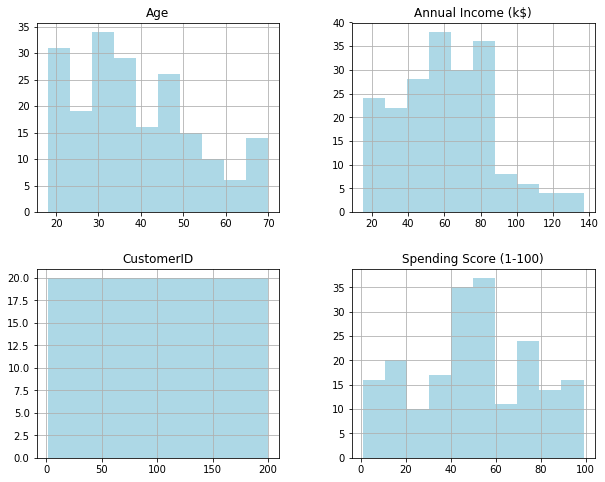

In [9]:
df.hist(figsize = (10,8),bins =10, grid=True, color='lightblue')

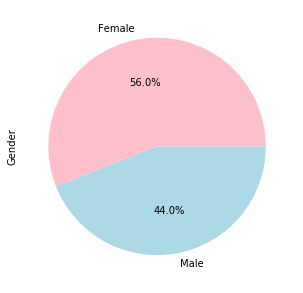

In [10]:
df['Gender'].value_counts().plot(kind='pie',autopct='%1.1f%%', colors = ['pink', 'lightblue'], figsize=(5,5))

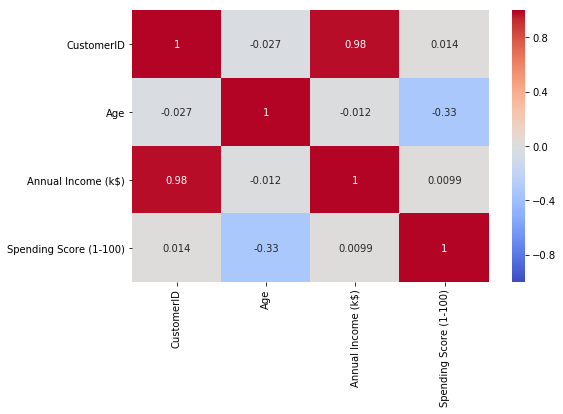

In [11]:
corr_values = df.corr()
plt.figure(figsize = (8,5))
sns.heatmap(corr_values, vmin = -1, cmap="coolwarm", annot=True)
plt.show()

## Data Preprocessing

In [12]:
# Binning numeric variables
df['Age_binned'] = pd.cut(df['Age'], 5)
df['Annual_Income_binned'] = pd.cut(df['Annual Income (k$)'], 5)
df['Spending_Score_binned'] = pd.cut(df['Spending Score (1-100)'], 5)

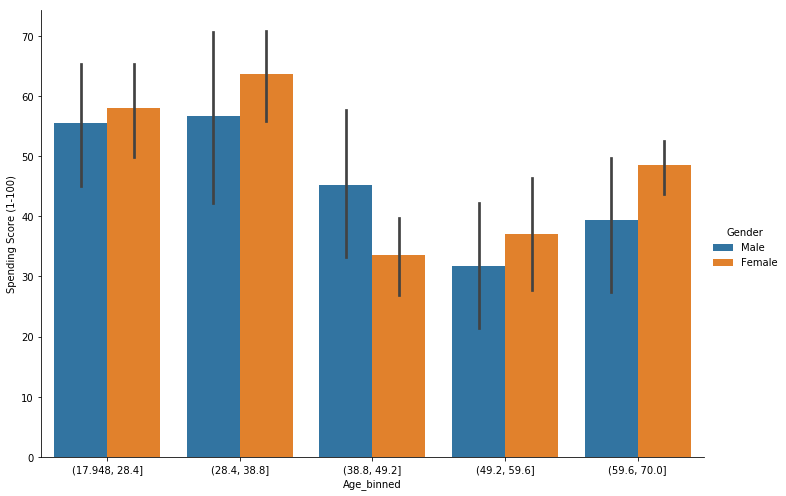

In [13]:
sns.catplot(x='Age_binned', y='Spending Score (1-100)', hue='Gender',kind="bar", data=df, height=7, aspect=10/7)

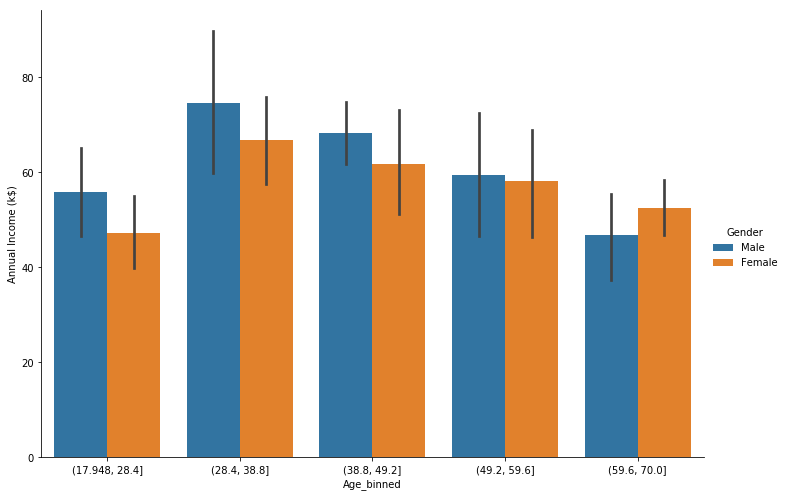

In [14]:
sns.catplot(x='Age_binned', y='Annual Income (k$)', hue='Gender',kind="bar", data=df, height=7, aspect=10/7)

In [15]:
# dropping unnecessary data
df = df.drop(columns=['CustomerID', 'Age_binned', 'Annual_Income_binned', 'Spending_Score_binned'])

NOTE: I tried clustering using binned values but the results were a bit ambigious so I decided to stick with numeric values

In [16]:
# Label Encoding binned and categorical values
print(df.head())
print('-'*70)

le = LabelEncoder()
for i in ['Gender']:
    df[i] = le.fit_transform(df[i])

print(df.head())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0    Male   19                  15                      39
1    Male   21                  15                      81
2  Female   20                  16                       6
3  Female   23                  16                      77
4  Female   31                  17                      40
----------------------------------------------------------------------
   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       1   19                  15                      39
1       1   21                  15                      81
2       0   20                  16                       6
3       0   23                  16                      77
4       0   31                  17                      40


## K-Means Clustering

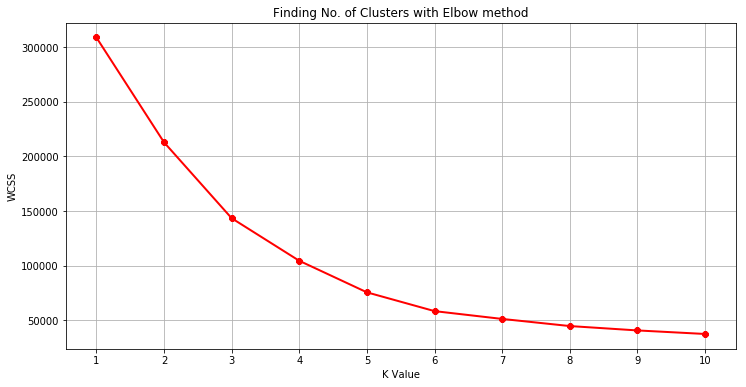

In [17]:
from sklearn.cluster import KMeans, DBSCAN 
wcss = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11), wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.title("Finding No. of Clusters with Elbow method")
plt.show()

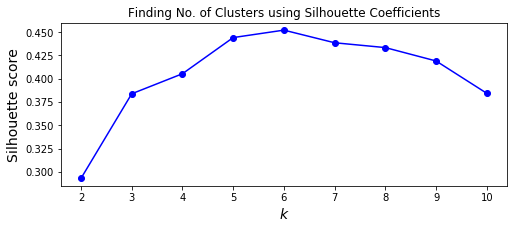

In [18]:
from sklearn.metrics import silhouette_score
kmeans_models = [KMeans(n_clusters=k, random_state=7).fit(df) for k in range(1, 11)]

silhouette_scores = [silhouette_score(df, model.labels_) for model in kmeans_models[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Finding No. of Clusters using Silhouette Coefficients")
plt.show()

From Elbow Method the elbow forms around 6 clusters and silhouette score is maximum for k=6 in the curve. This concludes that optimal number of clusters for customer segmentation is **6 Clusters**

### Fitting K-means with optimal cluster centers

In [19]:
# Fitting optimal number of clusters on data 
kmeans = KMeans(n_clusters=6, init="k-means++")
kmeans.fit(df)

# Assigning label to each customer
df['km_segment'] = kmeans.labels_

### Visualizing Clustering results with PCA

,0,1,2,3,km_segment
0,-31.869945,-33.001252,-22.142987,0.633880,5
1,0.764494,-56.842901,-10.542634,0.665413,3
2,-57.408276,-13.124961,-28.750964,-0.396334,5
3,-2.168543,-53.478590,-9.511588,-0.342385,3
4,-32.174085,-30.388412,-10.225069,-0.387778,5


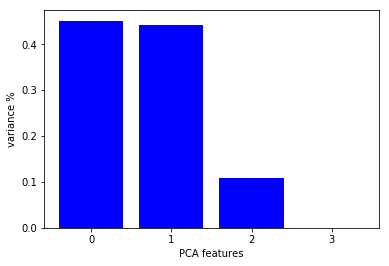

In [20]:
from sklearn.decomposition import PCA

# Create a PCA instance: pca
pca = PCA()
principalComponents = pca.fit_transform(df.iloc[:,:-1]) #excluding the segment while fitting

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
PCA_components = pd.concat((PCA_components, df['km_segment']), axis=1)
PCA_components.head()

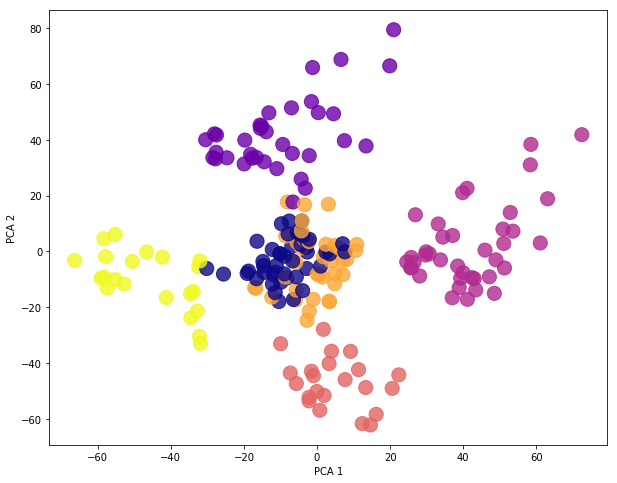

In [21]:
plt.figure(figsize=(10,8))
plt.scatter(PCA_components[0], PCA_components[1], alpha=0.8, 
            s=200, c = PCA_components['km_segment'], cmap='plasma')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## DBSCAN for Clustering

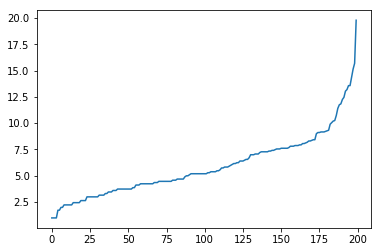

In [22]:
# Estimating the value of epsilon by calculating pariwise distances between samples and choosing
# the epsilon where the distance suddenly spikes

from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df.iloc[:,:-1])
distances, indices = nbrs.kneighbors(df.iloc[:,:-1])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [23]:
# fit the DBSCAN 
db = DBSCAN(eps=11, min_samples=3).fit(df.iloc[:,:-1]) 
df['db_segment'] = db.labels_

In [24]:
PCA_components = pd.concat((PCA_components, df['db_segment']), axis=1)
PCA_components.head()

,0,1,2,3,km_segment,db_segment
0,-31.869945,-33.001252,-22.142987,0.633880,5,-1
1,0.764494,-56.842901,-10.542634,0.665413,3,0
2,-57.408276,-13.124961,-28.750964,-0.396334,5,-1
3,-2.168543,-53.478590,-9.511588,-0.342385,3,0
4,-32.174085,-30.388412,-10.225069,-0.387778,5,1


In [25]:
# Clusters by DBSCAN -1 represents noise 
df.db_segment.value_counts()

 0    102
 2     34
 3     23
-1     18
 1     16
 5      4
 4      3
Name: db_segment, dtype: int64

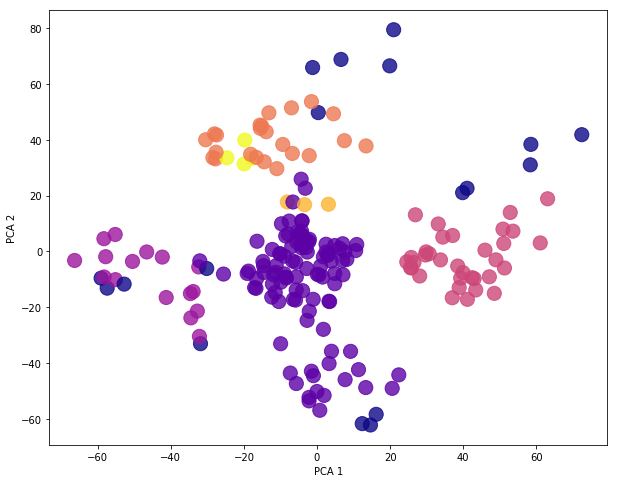

In [29]:
plt.figure(figsize=(10,8))
plt.scatter(PCA_components[0], PCA_components[1], alpha=0.8, 
            s=200, c = PCA_components['db_segment'], cmap='plasma')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

**Observation:** Although DBSCAN automatically finds the clusters within the data it is very sensitive to its parameters epsilon and min_samples. K-means on the other hand seems to accurately cluster the datapoints as shown in the PCA plot where the cluster centers were verified using both elbow method and silhouette coefficients.